<a href="https://colab.research.google.com/github/YoniTint/trust-ai-project/blob/hila/trustuworth_ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download data

In [ ]:
### CURRENTLY NOT TESTED YET SO DON'T USE!!
# import requests
# import zipfile
# from pathlib import Path

# # Setup path to a data folder
# image_path = Path(r"/content/drive/MyDrive/Colab Notebooks/trustworthy_ml/data/celeba-dataset")

# # If the image folder doesn't exist, download it and prepare it...
# if image_path.is_dir():
#   print(f"{image_path} directory already exists... skipping download")
# else:
#   print(f"{image_path} does not exists, creating one...")
#   image_path.mkdir(parents=True, exist_ok=True)

#   # Unzip celeba data
#   with zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/trustworthy_ml/data/celeba-dataset.zip", "r") as zip_ref:
#     print("Unzipping celeba data...")
#     zip_ref.extractall(image_path)

##Loading libraries##

In [2]:
!pip install grad-cam
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=698ec8a2aff80d430f35470cee28d12eddd38e7e58d20505a3aa482c08ca4e78
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.6/605.6 kB 8.4 MB/s eta 0:00:00


## Import Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image
from google.colab.patches import cv2_imshow
from pathlib import Path
import os
import pandas as pd
from matplotlib import pyplot as plt

# Functions

In [4]:
COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color,
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img

def preprocess_image(image_url, is_local_image=True, nm_imgs=1, index=1, metadata_df=None):
  if is_local_image:
    img = cv2.imread(image_url + '/' + metadata_df.sample(nm_imgs)["image_id"].values[index])
  else:
    img = np.array(Image.open(requests.get(image_url, stream=True).raw))
  img = cv2.resize(img, (640, 640)) # YOLO expects exactly 640 shape to work
  rgb_img = img.copy()
  img = np.float32(img) / 255
  transform = transforms.ToTensor()
  image_as_tensor = transform(img).unsqueeze(0)

  return image_as_tensor, rgb_img, img

def load_model(model_path, model_name):
  model = torch.hub.load(model_path, model_name, pretrained=True)
  model.eval()
  model.cpu()
  # Yolo need the one before the last, change for other models?
  target_layers = [model.model.model.model[-2]]

  return model, target_layers

def add_bboxes_to_image(model, rgb_img):
  results = model([rgb_img])
  boxes, colors, names = parse_detections(results)
  detections = draw_detections(boxes, colors, names, rgb_img.copy())

  return detections

def activate_grad_cam_on_image(model, target_layers, image_as_tensor, img):
  # Flags work for now, if configuration needed, will be not hardcoded
  cam = EigenCAM(model, target_layers, use_cuda=False)
  grayscale_cam = cam(image_as_tensor)[0, :, :]
  cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

  heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), colormap)
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

  return cam_image, heatmap

In [5]:
# INIT COLORMAP VARIABLE
colormap = cv2.COLORMAP_JET

##Example on one image from the internet##

Using yolo5 model to detect a person

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

requirements: Ultralytics requirement ['gitpython>=3.1.30'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 13.3 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 4.1s, installed 1 package: ['gitpython>=3.1.30']
requirements: ⚠️ Restar

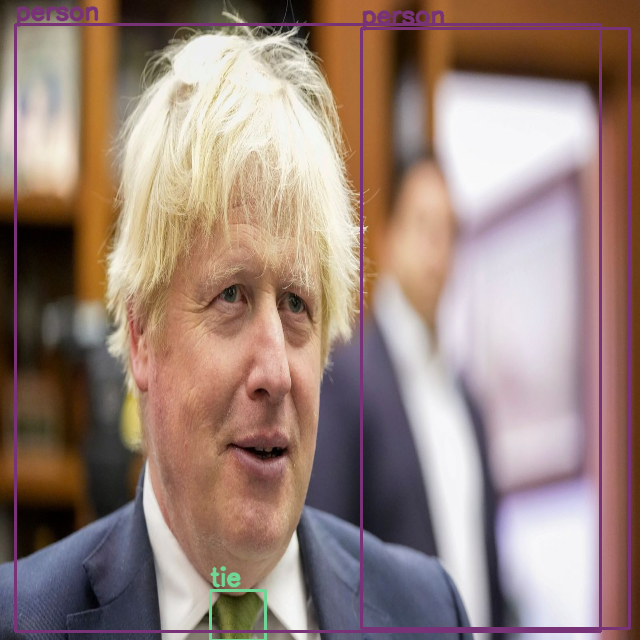

In [7]:
IMAGE_URL = "https://e3.365dm.com/23/05/1600x900/skynews-boris-johnson-texas_6165501.jpg?20230524053259"

image_as_tensor, rgb_img, img = preprocess_image(IMAGE_URL, is_local_image=False)

model, target_layers = load_model('ultralytics/yolov5', 'yolov5s')

image_with_bboxes = add_bboxes_to_image(model, rgb_img)
Image.fromarray(image_with_bboxes)

Using grad-cam to create abstract shaped noise

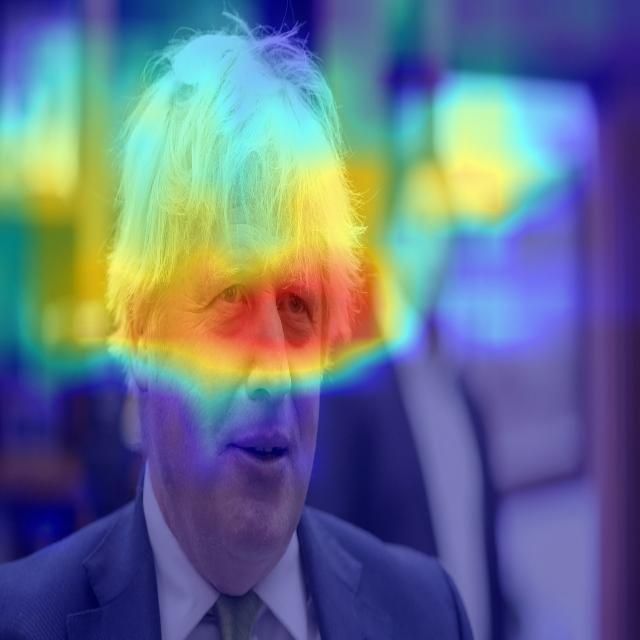

In [8]:
grad_cam_activated_image, activated_image_heatmap = activate_grad_cam_on_image(model, target_layers, image_as_tensor, img)
Image.fromarray(grad_cam_activated_image)

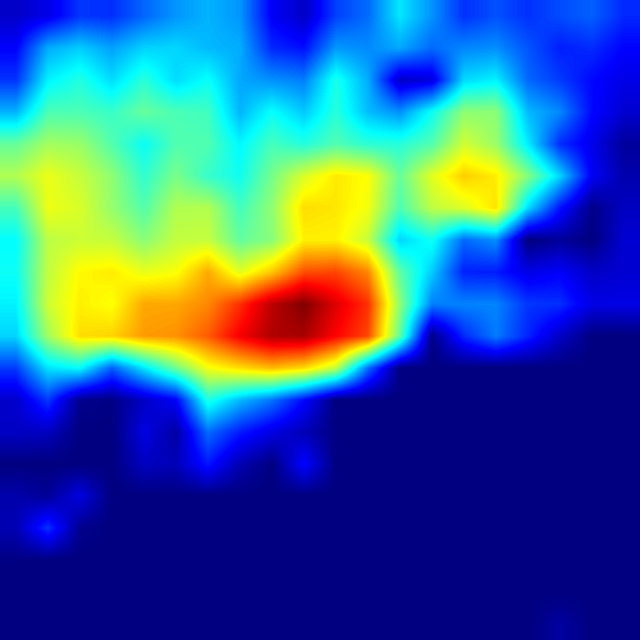

In [9]:
Image.fromarray(activated_image_heatmap)

## PGD first iteration

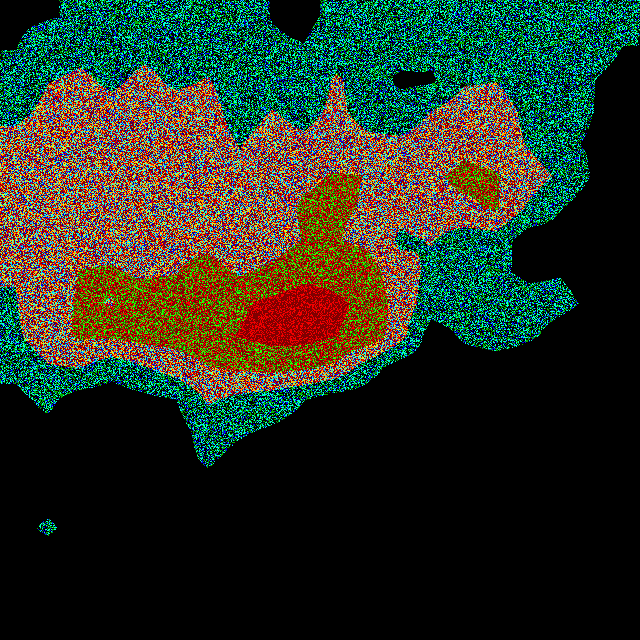

In [10]:
eps = 1e-5
variance = 0.01
delta = torch.zeros(img.shape[0], img.shape[1], 3, dtype=torch.float64)
delta = delta + variance * torch.randn(img.shape[0], img.shape[1], 3)  * 255

# clip delta to be within [delta-eps, delta+eps]
delta = torch.clamp(delta, delta-eps, delta + eps)

# clip delta to be between 0 and 1
delta[np.where(activated_image_heatmap == 0)] = 0

delta_img = cv2.applyColorMap(np.uint8(delta), cv2.COLORMAP_JET)
delta_img[np.where(activated_image_heatmap == 0)] = 0
Image.fromarray(delta_img)

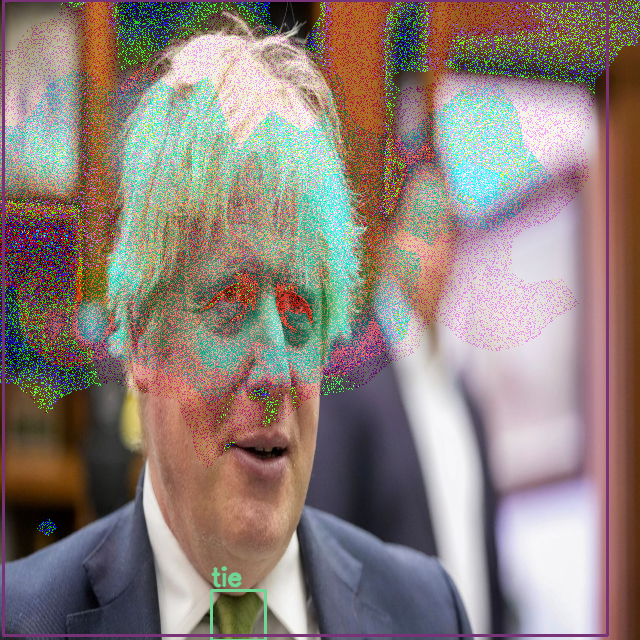

In [11]:
img = np.array(Image.open(requests.get(IMAGE_URL, stream=True).raw))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
noisy = rgb_img + delta_img

# give predictions on noisy image
results = model([noisy])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, noisy.copy())
Image.fromarray(detections)

##Results on a dataset##
Now we'll try to get results for a full data set. this dataset is taken from: https://datasets.activeloop.ai/docs/ml/datasets/celeba-dataset/.

In [12]:
cd /content/drive/MyDrive/Colab Notebooks/trustworthy_ml/data

/content/drive/MyDrive/Colab Notebooks/trustworthy_ml/data


### Checking that dataset exists in the drive

In [13]:
# How many images we will look on from the dataset
NM_IMGS = 3

In [14]:
BASIC_PATH = r"/content/drive/MyDrive/Colab Notebooks/trustworthy_ml/data/data/celeba"
FEATURE_PATH = os.path.join(BASIC_PATH,'list_attr_celeba.csv')
IMG_PATH = os.path.join(BASIC_PATH,'img_align_celeba/img_align_celeba')
pd.set_option('display.max_colwidth', None)

df = pd.read_csv(FEATURE_PATH, nrows=NM_IMGS)
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,...,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,...,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,...,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,...,-1,-1,-1,-1,1


## Testing the model on the dataset

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-7-30 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


image 0 stopped after 1 iterations


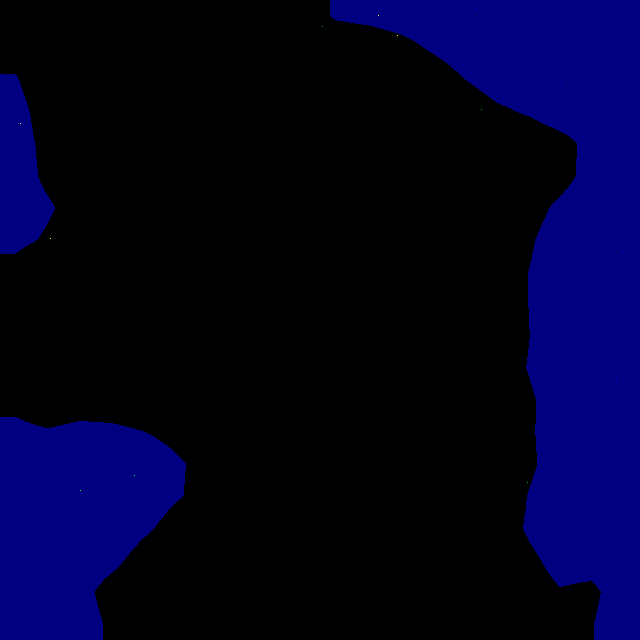

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-7-30 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


image 1 stopped after 1 iterations


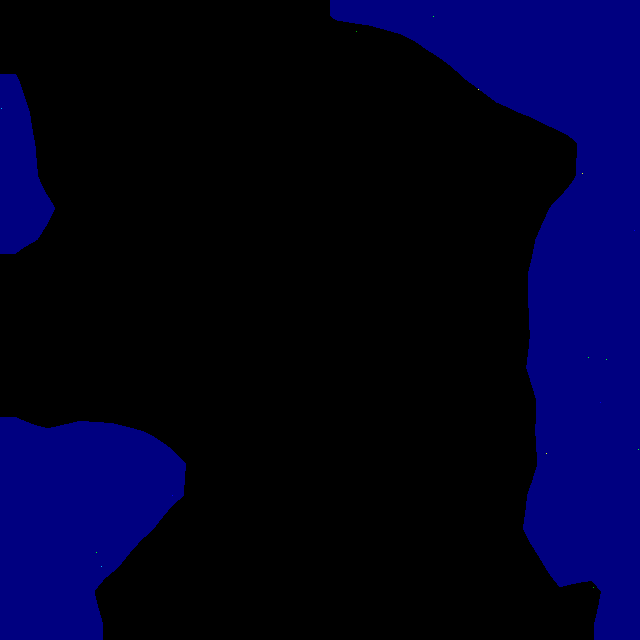

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-7-30 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


image 2 stopped after 2 iterations


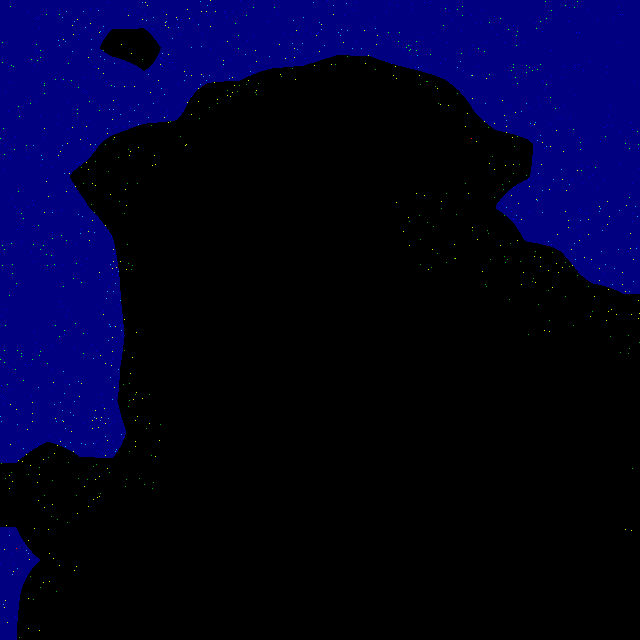

In [15]:
from google.colab.patches import cv2_imshow
outputs_folder = r"/content/drive/MyDrive/Colab Notebooks/trustworthy_ml/data/data/celeba/img_align_celeba/img_align_celeba/outputs"

for index in range(0, NM_IMGS):
    image_as_tensor, rgb_img, img = preprocess_image(IMG_PATH, is_local_image=True, nm_imgs=NM_IMGS, index=index, metadata_df=df)

    model, target_layers = load_model('ultralytics/yolov5', 'yolov5s')

    image_with_bboxes = add_bboxes_to_image(model, rgb_img)

    grad_cam_activated_image, activated_image_heatmap = activate_grad_cam_on_image(model, target_layers, image_as_tensor, img)

    max_iter = 1000
    delta = torch.zeros(img.shape[0], img.shape[1], 3, dtype=torch.float64)
    for i in range(max_iter):
      eps = 1e-5
      variance = 0.001
      delta = delta + variance * torch.randn(img.shape[0], img.shape[1], 3)  * 255
      # clip delta to be within [delta-eps, delta+eps]

      delta = torch.clamp(delta, delta-eps, delta + eps)
      # clip delta to be between 0 and 1
      # delta = torch.clamp(delta, 0, 1)
      delta[np.where(activated_image_heatmap == 0)] = 0

      delta_img = cv2.applyColorMap(np.uint8(delta), colormap)
      delta_img[np.where(activated_image_heatmap == 0)] = 0
      Image.fromarray(delta_img)

      img = cv2.imread(IMG_PATH + '/' + df.sample(NM_IMGS)["image_id"].values[index])
      img = cv2.resize(img, (640, 640))
      rgb_img = img.copy()
      noisy = rgb_img + delta_img

      # give predictions on noisy image
      results = model([noisy])
      boxes, colors, names = parse_detections(results)
      detections = draw_detections(boxes, colors, names, noisy.copy())
      Image.fromarray(detections)
      if (len(boxes) == 0) or (not 'person' in names):
        cv2.imwrite(f"{outputs_folder}/{index}.png", detections)
        print(f'image {index} stopped after {i+1} iterations')
        cv2_imshow(delta_img)
        break

We can see that when the variance of the added noise is small, the miss-detection is faster (1-2 itarations).
Now we'll check with higher variance:

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-7-30 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


image 0 stopped after 1 iterations


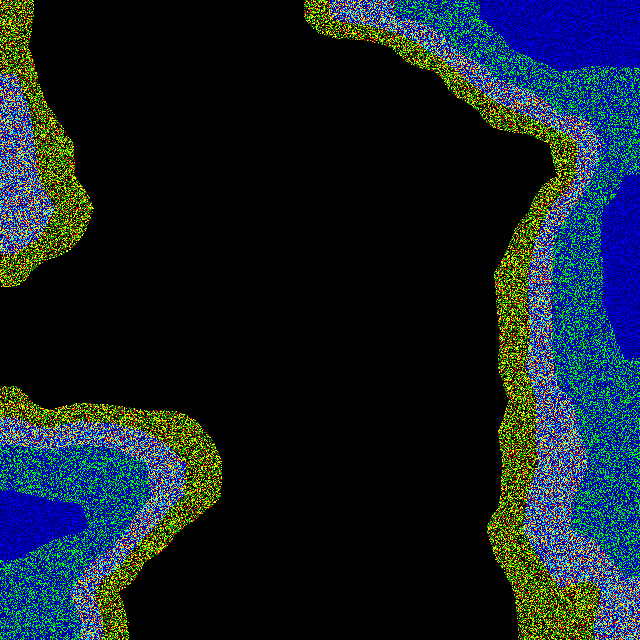

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-7-30 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


image 1 stopped after 4 iterations


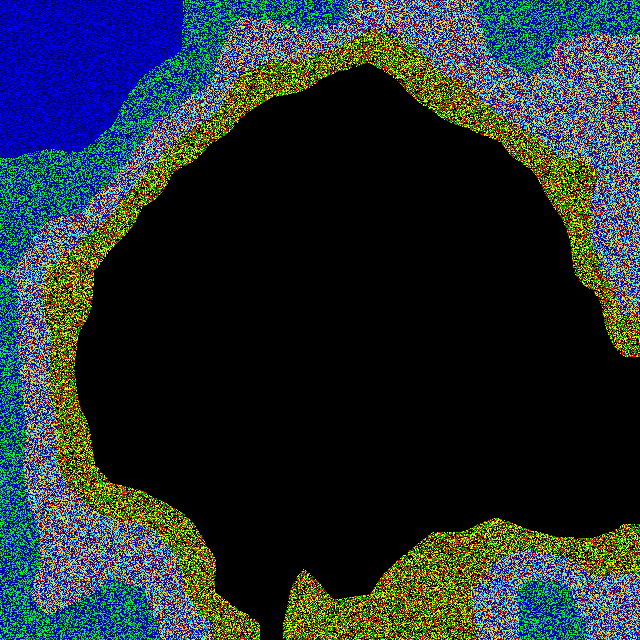

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-7-30 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


image 2 stopped after 1 iterations


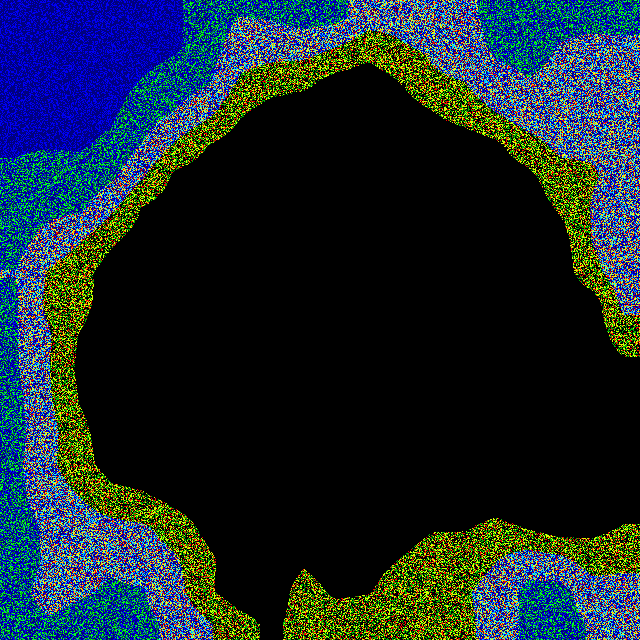

In [16]:
from google.colab.patches import cv2_imshow
outputs_folder = r"/content/drive/MyDrive/Colab Notebooks/trustworthy_ml/data/data/celeba/img_align_celeba/img_align_celeba/outputs"

for index in range(0, NM_IMGS):
    img = cv2.imread(IMG_PATH + '/' + df.sample(NM_IMGS)["image_id"].values[index])
    img = cv2.resize(img, (640, 640))
    rgb_img = img.copy()
    img = np.float32(img) / 255
    transform = transforms.ToTensor()
    tensor = transform(img).unsqueeze(0)

    model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
    model.eval()
    model.cpu()
    target_layers = [model.model.model.model[-2]]

    results = model([rgb_img])
    boxes, colors, names = parse_detections(results)
    detections = draw_detections(boxes, colors, names, rgb_img.copy())
    Image.fromarray(detections)
    cam = EigenCAM(model, target_layers, use_cuda=False)
    grayscale_cam = cam(tensor)[0, :, :]
    cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    Image.fromarray(cam_image)
    colormap = cv2.COLORMAP_JET
    heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    Image.fromarray(heatmap)
    max_iter = 1000
    delta = torch.zeros(img.shape[0], img.shape[1], 3, dtype=torch.float64)
    for i in range(max_iter):
      eps = 1e-5
      variance = 0.01
      delta = delta + variance * torch.randn(img.shape[0], img.shape[1], 3)  * 255
      # clip delta to be within [delta-eps, delta+eps]
      delta = torch.clamp(delta, delta-eps, delta + eps)
      # clip delta to be between 0 and 1
      delta[np.where(heatmap == 0)] = 0

      delta_img = cv2.applyColorMap(np.uint8(delta), colormap)
      delta_img[np.where(heatmap == 0)] = 0
      Image.fromarray(delta_img)

      img = cv2.imread(IMG_PATH + '/' + df.sample(NM_IMGS)["image_id"].values[index])
      img = cv2.resize(img, (640, 640))
      rgb_img = img.copy()
      noisy = rgb_img + delta_img

      # give predictions on noisy image
      results = model([noisy])
      boxes, colors, names = parse_detections(results)
      detections = draw_detections(boxes, colors, names, noisy.copy())
      Image.fromarray(detections)
      if (len(boxes) == 0) or (not 'person' in names):
        cv2.imwrite(f"{outputs_folder}/{index}.png", detections)
        print(f'image {index} stopped after {i+1} iterations')
        cv2_imshow(delta_img)
        break

## Finding the weakness in the model using full PGD algorithm (currently not working - will be resolved later)

In [ ]:
from google.colab.patches import cv2_imshow
import torch.nn.functional as F
outputs_folder = r"/content/drive/MyDrive/Colab Notebooks/trustworthy_ml/data/data/celeba/img_align_celeba/img_align_celeba/outputs"

for index in range(0, NM_IMGS):
    img = cv2.imread(IMG_PATH + '/' + df.sample(NM_IMGS)["image_id"].values[index])
    img = cv2.resize(img, (640, 640))
    rgb_img = img.copy()
    img = np.float32(img) / 255
    transform = transforms.ToTensor()
    tensor = transform(img).unsqueeze(0)

    model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
    model.eval()
    model.cpu()
    target_layers = [model.model.model.model[-2]]

    results = model([rgb_img])
    true_boxes, colors, true_names = parse_detections(results)
    detections = draw_detections(true_boxes, colors, true_names, rgb_img.copy())
    Image.fromarray(detections)
    cam = EigenCAM(model, target_layers, use_cuda=False)
    grayscale_cam = cam(tensor)[0, :, :]
    cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    Image.fromarray(cam_image)
    colormap = cv2.COLORMAP_JET
    heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    Image.fromarray(heatmap)
    max_iter = 1000

    eps = 1e-5
    delta = torch.zeros(img.shape[0], img.shape[1], 3, dtype=torch.float64).uniform_(-eps, eps)
    delta = cv2.applyColorMap(np.uint8(delta), colormap)
    delta[np.where(heatmap == 0)] = 0
    Image.fromarray(delta)


    x_adv = torch.tensor(rgb_img).clone()
    x_adv = torch.clamp(torch.tensor(x_adv + delta), 0, 1).detach()
    x_adv = cv2.applyColorMap(np.uint8(x_adv) *255, colormap)

    C=1000
    alpha = 1/255.
    for i in range(max_iter):
      # give predictions on noisy image
      results = model([x_adv])
      boxes, colors, names = parse_detections(results)
      loss_bb = F.l1_loss(torch.tensor(boxes), torch.tensor(true_boxes), reduction="none").sum(1)
      loss = loss_bb/C
      grad = torch.sign(torch.autograd.grad(loss, torch.tensor(x_adv), retain_graph=False, create_graph=False)[0])
      x_adv = x_adv.detach() + alpha * grad
      x_adv = torch.clamp(x_adv, rgb_img - eps, rgb_img + eps)
      x_adv = torch.clamp(x_adv, 0, 1).detach_()
      x_adv = cv2.applyColorMap(np.uint8(x_adv) *255, colormap)
      cv2_imshow(x_adv)
      detections = draw_detections(boxes, colors, names, noisy.copy())
      Image.fromarray(detections)

      if (len(boxes) == 0) or (not 'person' in names):
        cv2.imwrite(f"{outputs_folder}/{index}.png", detections)
        print(f'image {index} stopped after {i+1} iterations')
        cv2_imshow(x_adv)
        break

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-7-24 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


RuntimeError: ignored

Trying different kinds of noise

Gussian noise

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-7-30 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


image 0 stopped after 2 iterations


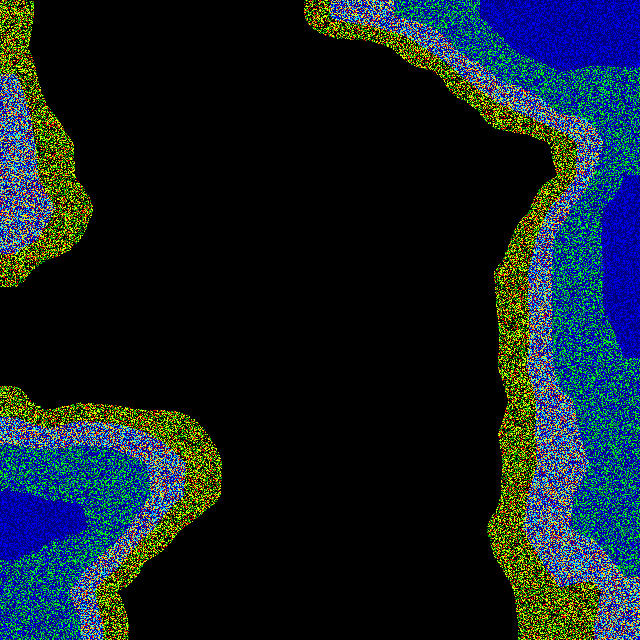

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-7-30 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


image 1 stopped after 1 iterations


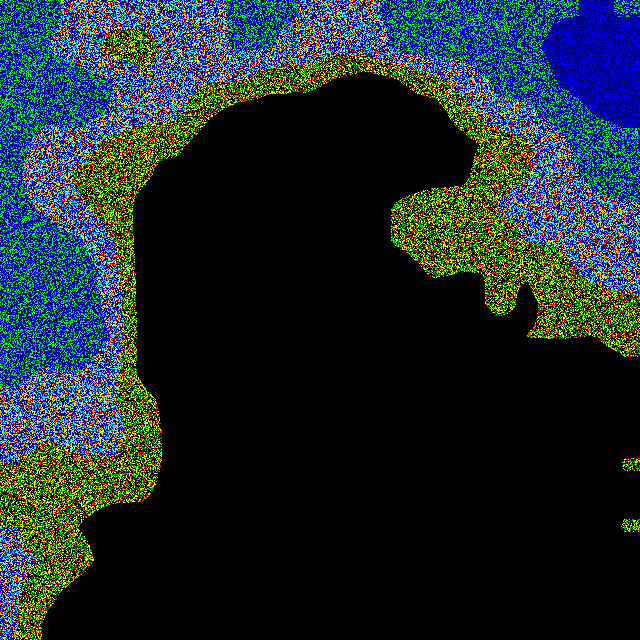

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-7-30 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


image 2 stopped after 1 iterations


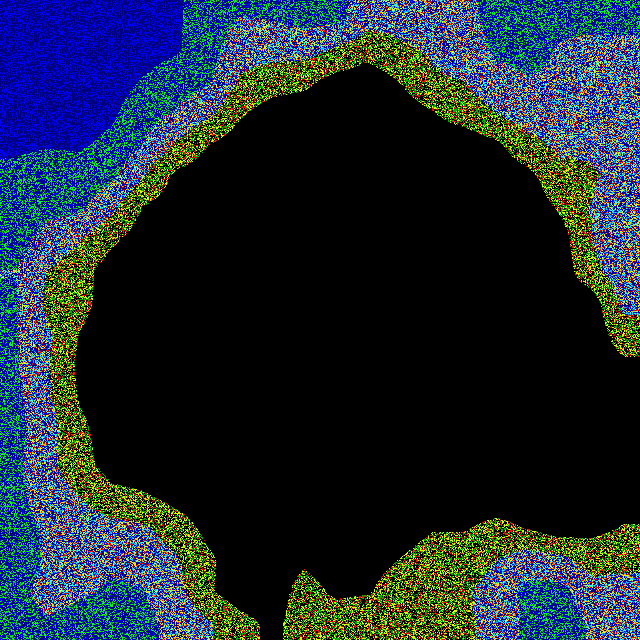

In [99]:
from google.colab.patches import cv2_imshow
outputs_folder = r"/content/drive/MyDrive/Colab Notebooks/trustworthy_ml/data/data/celeba/img_align_celeba/img_align_celeba/outputs"

for index in range(0, NM_IMGS):
    image_as_tensor, rgb_img, img = preprocess_image(IMG_PATH, is_local_image=True, nm_imgs=NM_IMGS, index=index, metadata_df=df)

    model, target_layers = load_model('ultralytics/yolov5', 'yolov5s')

    image_with_bboxes = add_bboxes_to_image(model, rgb_img)

    grad_cam_activated_image, activated_image_heatmap = activate_grad_cam_on_image(model, target_layers, image_as_tensor, img)

    max_iter = 10
    delta = torch.zeros(img.shape[0], img.shape[1], 3, dtype=torch.float64)
    for i in range(max_iter):
      eps = 1e-5
      mean = 0
      sigma = 0.01
      noise = torch.tensor(np.random.normal(mean, sigma, (img.shape[0],img.shape[1],3))) * 255
      delta = torch.clamp(noise, noise-eps, noise + eps)

      delta[np.where(activated_image_heatmap == 0)] = 0
      delta_img = cv2.applyColorMap(np.uint8(delta), colormap)
      delta_img[np.where(activated_image_heatmap == 0)] = 0

      img = cv2.imread(IMG_PATH + '/' + df.sample(NM_IMGS)["image_id"].values[index])
      img = cv2.resize(img, (640, 640))
      rgb_img = img.copy()
      noisy = rgb_img + delta_img
      noisy = np.clip(noisy, 0, 255)

      # give predictions on noisy image
      results = model([noisy])
      boxes, colors, names = parse_detections(results)
      detections = draw_detections(boxes, colors, names, noisy.copy())
      Image.fromarray(detections)
      if (len(boxes) == 0) or (not 'person' in names):
        cv2.imwrite(f"{outputs_folder}/gaussian_img_{index}.png", detections)
        print(f'image {index} stopped after {i+1} iterations')
        cv2_imshow(delta_img)
        break